In [1]:
import glob
import os
import pandas as pd
import numpy as np
from dbfread import DBF
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
from scipy.stats import yeojohnson
from sklearn.metrics import r2_score
from tqdm import tqdm
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Import data

In [2]:
# Direct path to the specific shapefile
shp_file = '../../Data/Processed/PT-FireSprd_v3.0/L2_FireBehavior/PT-FireSprd_v3.0_L2_model.shp'

processed_folder = Path("../../Data/Processed/PT-FireSprd_v3.0/L2_FireBehavior/")

gdf = gpd.read_file(shp_file)

In [3]:
gdf = gdf.replace([-1, -999], np.nan)

### log transformation

In [4]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd

# Colunas a EXCLUIR
c = ["fuel_model", "landform", "land_use"]

# Criar cópia da gdf original para a versão log
gdf_log = gdf.copy()

# Selecionar colunas numéricas, exceto as em c e a geometria
valid_cols = [
    col for col in gdf_log.select_dtypes(include=[np.number]).columns
    if col not in c
]

print(f"Applying log transform to {len(valid_cols)} columns")

# Substituir valores inválidos
gdf_log[valid_cols] = gdf_log[valid_cols].replace([-1, -999], np.nan)

# Transformação sign(x) * log(|x| + 1)
gdf_log[valid_cols] = gdf_log[valid_cols].apply(
    lambda s: np.sign(s) * np.log(np.abs(s) + 1)
)

# Guardar shapefile com sufixo _log
base = os.path.splitext(os.path.basename(shp_file))[0]
output_path = os.path.join(processed_folder, f"{base}_log.shp")
print(f"Saving {output_path}...")
gdf_log.to_file(output_path)

# Guardar a gdf_log na variável dataframes
if 'dataframes' not in globals():
    dataframes = {}

dataframes[f"{base}_log"] = gdf_log

print("All files processed.")

Applying log transform to 107 columns
Saving ..\..\Data\Processed\PT-FireSprd_v3.0\L2_FireBehavior\PT-FireSprd_v3.0_L2_model_log.shp...
All files processed.


### Plot ROS_P Distribution

c:\Conda\envs\firehack\Lib\site-packages\matplotlib\scale.py:170: RuntimeWarning: divide by zero encountered in log
  return self._forward(values)
c:\Conda\envs\firehack\Lib\site-packages\matplotlib\axis.py:1540: RuntimeWarning: One of rtol or atol is not valid, atol: inf, rtol: 0
  mask = np.isclose(tr_minor_locs[:, None], tr_major_locs[None, :],


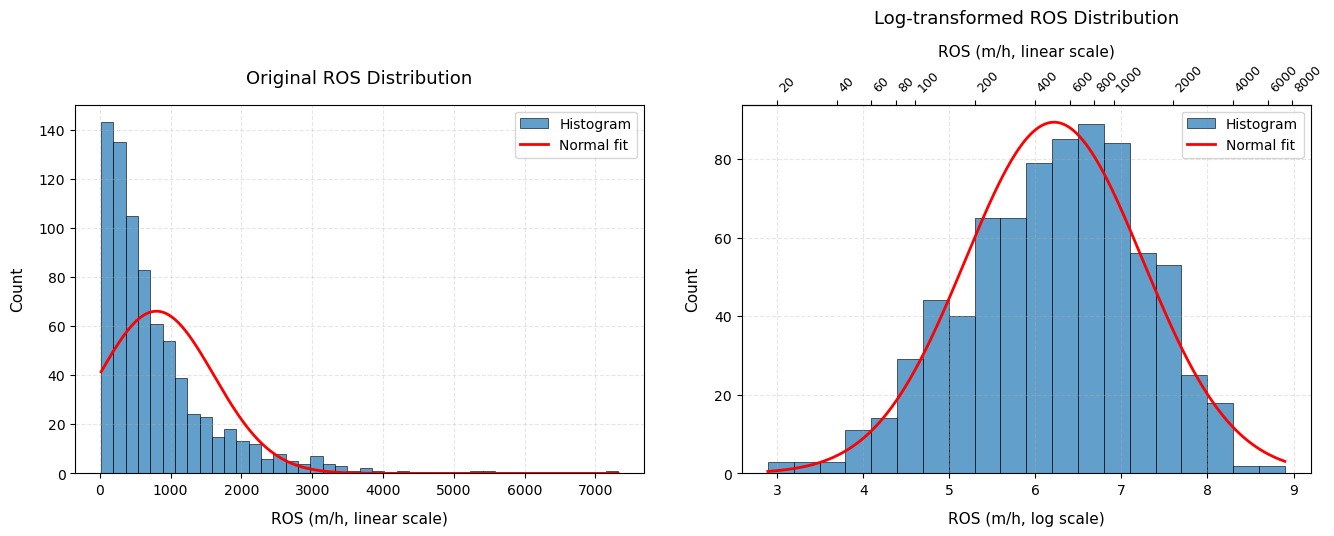


Original - D’Agostino–Pearson Normality Test
Statistic: 422.9806, p-value: 1.4155e-92
Reject H₀ (data is likely not normal).

Log-transformed - D’Agostino–Pearson Normality Test
Statistic: 15.1887, p-value: 5.0330e-04
Reject H₀ (data is likely not normal).


In [5]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy import stats
import numpy as np
import pandas as pd

# Supondo que você tenha gdf (original) e gdf_log (log-transformado)
datasets = {
    "Original": gdf,
    "Log-transformed": gdf_log
}

plt.figure(figsize=(14, 6))  # Largura maior para dois plots

for i, (name, df) in enumerate(datasets.items(), 1):
    # Convert ros_p to numeric and drop NaNs
    ros_data = pd.to_numeric(df["ros_p"], errors="coerce").dropna()

    ax = plt.subplot(1, 2, i)

    # Histograma em contagem
    counts, bins, patches = ax.hist(
        ros_data,
        bins="fd",
        alpha=0.7,
        edgecolor="black",
        linewidth=0.6,
        label="Histogram"
    )

    # Normal distribution fit ajustada à contagem
    mu, sigma = ros_data.mean(), ros_data.std()
    x = np.linspace(ros_data.min(), ros_data.max(), 500)
    y = stats.norm.pdf(x, mu, sigma)
    y_scaled = y * len(ros_data) * (bins[1] - bins[0])
    ax.plot(x, y_scaled, color="red", linewidth=2, label="Normal fit")

    # Título e labels com padding
    ax.set_title(f"{name} ROS Distribution", fontsize=13, pad=15)
    ax.set_xlabel("ROS (m/h, linear scale)", fontsize=11, labelpad=10)
    ax.set_ylabel("Count", fontsize=11, labelpad=10)
    ax.grid(True, linestyle="--", alpha=0.3)
    ax.legend()

    # Ajustar ticks para não sobrepor
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # força ticks inteiros

    # Eixo secundário para o log-transformado
    if "Log" in name:
        # Criar eixo secundário X que mostra ROS linear
        ax2 = ax.secondary_xaxis('top', functions=(np.exp, np.log))

        # Criar ticks escalonados manualmente
        ticks = list(range(0, 101, 20))        
        ticks += list(range(0, 1001, 200))    
        ticks += list(range(0, 10001, 2000)) 
        ax2.set_xticks(ticks)

        # Rotacionar ticks se necessário para não sobrepor
        plt.setp(ax2.get_xticklabels(), rotation=45, ha='left', fontsize=9)

        ax.set_xlabel("ROS (m/h, log scale)", fontsize=11, labelpad=10)
        ax2.set_xlabel("ROS (m/h, linear scale)", fontsize=11, labelpad=5)

plt.tight_layout(pad=3.0)  # aumenta espaço entre plots
plt.show()

# Teste de normalidade para cada
for name, df in datasets.items():
    ros_data = pd.to_numeric(df["ros_p"], errors="coerce").dropna()
    stat, p_value = stats.normaltest(ros_data)
    print(f"\n{name} - D’Agostino–Pearson Normality Test")
    print(f"Statistic: {stat:.4f}, p-value: {p_value:.4e}")
    if p_value > 0.05:
        print("Fail to reject H₀ (data appears normal).")
    else:
        print("Reject H₀ (data is likely not normal).")

